## Make Recommendations
    Train the model on the entire data set. 
    Recommend the top 5 wines from the top 5 varietals for each user. 
    These wines will be previously unpurchased wines by the user. 

#### Import Libraries

In [41]:
# increase area of notebook - good for plots 
# from IPython.core.display import HTML
# HTML("<style>.container { width:80% !important; }</style>")

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cPickle
from time import time
from sklearn.utils import shuffle
from collections import defaultdict, Counter
import pyspark
% matplotlib inline

In [2]:
from  pyspark import SparkContext
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel
import math

#### Import Data

In [3]:
home = "/Users/Alexander/Wine_Recommender/data/"
ratings_path = home + "spark_ready_data.pkl"
products_path = home + "wine_products.pkl"

In [92]:
products_df = pd.read_pickle(products_path)

In [93]:
# contains wine attributes like Appelations and Varietal
# will want to refer to this df once recommendations are made
products_df.head()

,ProductKey,ProductId,Appellation,Varietal,Vineyard,Class
0,2,127554,Napa Valley,Cabernet Sauvignon,Turnbull,Red Wines
1,3,133070,Napa Valley,Cabernet Sauvignon,Turnbull,Red Wines
2,4,114037,Napa Valley,Cabernet Sauvignon,Turnbull,Red Wines
5,7,109508,Napa Valley,Other Red Blends,Turnbull,Red Wines
6,8,110277,Napa Valley,Merlot,Turnbull,Red Wines


In [19]:
def get_ratings_data(ratings_path):
    start = time()
    data = cPickle.load(open(ratings_path, 'r'))
    end = time()
    print "Load Data Time Elapsed = {:.3} seconds".format(end - start)
    return data

In [24]:
data = get_ratings_data(ratings_path)

Time Elapsed = 20.1 seconds


In [25]:
len(data)

3737914

In [26]:
# format --> (user hash, product key, rating)
data[0:3]

[['00000F7264C27BA6FEA0C837ED6AA0AA', 202463, 9],
 ['00000F7264C27BA6FEA0C837ED6AA0AA', 202922, 6],
 ['00000F7264C27BA6FEA0C837ED6AA0AA', 214365, 6]]

### Note

The next couple of sections are here so that output from the various functions can be read. 
Scroll down to the Train Recommender header. Functions like create_cust_tag_bridge_rdd will be encapsulated in the train_recommender function so as to minimize memory useage.

Make sure to swift + enter each cell with the functions. Those functions will be used in train_recommender.

### Format Data for Spark Recommender
    Data needs to be in this form --> (user_id, item_id, n_purchases)

#### Create user tags/user ids bride rdd

In [6]:
def create_cust_tag_bridge_rdd(data, sc):
    # create int:cust_tag key value pairs
    # spark can't read string user ids
    
    unique_user_tags = np.unique([row[0] for row in data])
    
    index_to_int = np.arange(0, len(unique_user_tags) * 100, 100)
    cust_tag_bridge = [ (tag_hash, tag_int) for tag_hash, tag_int in zip(unique_user_tags, index_to_int)]
    
    return sc.parallelize(cust_tag_bridge)

In [28]:
cust_tag_bridge_rdd = create_cust_tag_bridge_rdd(data, sc)

In [34]:
cust_tag_bridge_rdd.take(2)

[('00000F7264C27BA6FEA0C837ED6AA0AA', 0),
 ('0000BE4B3C81E1CEF858D536BB740052', 100)]

In [32]:
type(cust_tag_bridge_rdd.map(lambda row: row[1]).take(1))

list

#### Wine Products RDD

In [5]:
def create_products_rdd(products_df):
    # create products_rdd
    products_rdd = sc.parallelize(products_df.values.tolist())
    
    # format --> (productKey, (productID, Appellation, Varietal, Vinyard) )
    products_rdd = products_rdd.map(lambda row: (row[0], (row[1], row[2], row[3], row[4], row[5]) )   )
    
    return products_rdd

In [95]:
products_rdd = create_products_rdd(products_df)

In [96]:
# format --> (productKey, (ProductID, Appellation, Varietal, Vineyard, Class) )
products_rdd.take(2)

[(2, (127554, 'Napa Valley', 'Cabernet Sauvignon', 'Turnbull', 'Red Wines')),
 (3, (133070, 'Napa Valley', 'Cabernet Sauvignon', 'Turnbull', 'Red Wines'))]

#### Ratings RDD

In [7]:
def create_clean_data_rdd(data, cust_tag_bridge_rdd):
    # create bride rdd for customer tags and customer ids
    data_rdd = sc.parallelize(data)
    
    tag_data_bridge_rdd = data_rdd.map(lambda row: (row[0], (row[1], row[2]) ))
    
    clean_data_rdd = \
    tag_data_bridge_rdd.sortByKey()\
                   .join( cust_tag_bridge_rdd.sortByKey())\
                   .map(lambda row: ( row[1][1], row[1][0][0], row[1][0][1]))
            
    return clean_data_rdd

In [15]:
clean_data_rdd = create_clean_data_rdd(data, cust_tag_bridge_rdd) 

In [16]:
# format --> (user_id, productKey, rating)
clean_data_rdd.take(3)

[(13793000, 11501, 0.93333333333333335),
 (13793000, 83729, 0.0047619047619047606),
 (13793000, 85684, 0.0047619047619047606)]

In [26]:
#clean_data_local = clean_data_rdd.collect()

In [28]:
# save spark ready data to file
spark_ready_data_path = "/Users/Alexander/WINE/data/spark_ready_data.pkl"
cPickle.dump(clean_data_local, open(spark_ready_data_path, "w"))

In [25]:
#load spark ready data 
# path = "/Users/Alexander/WINE/data/spark_ready_data.pkl"
# data = cPickle.load(open(path , 'r'))

### Create Train, Test, and Validation Sets

In [17]:
# split data into sets in appropriate proprotions, i.e. weights = [6, 2, 2]
training_RDD, validation_RDD, test_RDD = clean_data_rdd.randomSplit([6, 2, 2], seed=0)

In [18]:
# format data so that the key is (user_id, wine_feat)
validation_for_predict_RDD = validation_RDD.map(lambda x: (x[0], x[1]))
test_for_predict_RDD = test_RDD.map(lambda x: (x[0], x[1]))

In [19]:
# sanity check
training_RDD.take(5)

[(13793000, 83729, 0.0047619047619047606),
 (13793000, 85684, 0.0047619047619047606),
 (13793000, 175401, 0.0047619047619047606),
 (13793000, 391194, 0.0047619047619047606),
 (13793000, 423777, 0.0047619047619047606)]

In [20]:
validation_for_predict_RDD.take(5)

[(13793000, 109575),
 (13793000, 114390),
 (13793000, 392096),
 (13793000, 423538),
 (5219800, 159314)]

In [21]:
test_for_predict_RDD.take(5)

[(13793000, 11501),
 (13793000, 186881),
 (13793000, 253825),
 (13793000, 255098),
 (13793000, 354603)]

### Train Recommender
    Here we will train the model on the entire data set. 


#### Spark cluster
    Spark clusters can be created on a local or remote machine.
    In either case, the number of worker cups should always be, at most, 
    one less than the total number of cups available. 
    
    There are 4 cups on a typical laptop. 

In [8]:
# number of nodes in local spark cluster
n_worker_cups = 3
sc = pyspark.SparkContext(master = "local[{}]".format(n_worker_cups))

In [9]:
sc

In [10]:
def get_clean_data_rdd(sc, return_cust_brige_rdd = False):
    '''Loads ratings from master file and formats data into model readable form.
       data --> (user_id, productKey, rating)'''
    # load data
    data = get_ratings_data(ratings_path)
    # assigne each user hash tag a user_id
    cust_tag_bridge_rdd = create_cust_tag_bridge_rdd(data, sc)
    # model readable format
    clean_data_rdd = create_clean_data_rdd(data, cust_tag_bridge_rdd) 
    
    if return_cust_brige_rdd == False:
        cust_tag_bridge_rdd.unpersist()
        return clean_data_rdd
    else:
        return clean_data_rdd, cust_tag_bridge_rdd

In [10]:
def train_model(training_RDD):
    # TODO: still need to optimize hyperparameters in a grid search
    seed = 5L
    iterations = 30
    regularization_parameter = 0.1
    rank = 20

    model = ALS.train(training_RDD, 
                      rank=rank, 
                      seed=seed, 
                      iterations=iterations,
                      lambda_=regularization_parameter,
                      nonnegative=True)
    return model

In [11]:
def get_fitted_model(sc, ratings_path):
    '''Loads rating data from file, trains model, and returns a fitted model'''
    
    print "load data and build RDDs..."
    clean_data_rdd = get_clean_data_rdd(sc, return_bridge_rdd = False)
    
    print "Training Model..."
    start = time()
    fitted_model = train_model(clean_data_rdd )
    end = time()
    print "Training Model: Time Elapsed = {:.3} \n".format(end - start)
    
    # restore memory resources
    clean_data_rdd.unpersist()
    
    return fitted_model

In [12]:
start = time()
fitted_model  = get_fitted_model(sc, ratings_path )
end = time()
print "Time Elapsed = {:.3} seconds".format(end - start)

get_ratings_data...
Time Elapsed = 20.7 seconds
building RDDs....
Training Model...
Training Model: Time Elapsed = 2.88e+02 

Time Elapsed = 3.25e+02 seconds


In [12]:
# Save model
model_path = "/Users/Alexander/Wine_Recommender/models/spark_recommender"

In [13]:
# Save model
#fitted_model.save(sc ,model_path)

In [14]:
# load model
fitted_model = MatrixFactorizationModel.load(sc, model_path)

### Get K Recommendations for a Users
    1. For some ith user, remove their purchased wines from the total data.
    2. Get predicted rating on all previously unpurchased wines. 
    3. Filter recomendations based on the rating threshold vaule that was 
       validated in the model validation notebook. 
    4. Curate recommendations

### Get top K recommendations for an existing user

In [ ]:
# pick a user
# remove their wine ids from the total set
# get recommendations for that user
# filter recommendations based on threshold vaule
# curate recommendations 

In [25]:
# will get K predictions for user with this id
user_id = 0

In [20]:
clean_data_rdd, cust_tag_bridge_rdd = get_clean_data_rdd(sc, return_cust_brige_rdd = True)

Load Data Time Elapsed = 19.9 seconds


In [21]:
#Let's now get some recommendations! 
#For that we will get an RDD with all the movies the new user hasn't rated yet. 
#We will them together with the model to predict ratings.
clean_data_rdd.take(5)

[(13720100, 11501, 10),
 (13720100, 83729, 4),
 (13720100, 85684, 4),
 (13720100, 109575, 4),
 (13720100, 114390, 4)]

In [23]:
cust_tag_bridge_rdd.take(5)

[('00000F7264C27BA6FEA0C837ED6AA0AA', 0),
 ('0000BE4B3C81E1CEF858D536BB740052', 100),
 ('0000CFF17C117A02813740C93DC33507', 200),
 ('000233FB8CBD3FCD20304423156CDF39', 300),
 ('0002891908E9F41F05F440792B4FF2E7', 400)]

In [71]:
# ( user_id, movie_id, rating  )
# get user_id 0's movie ids in a list
movie_ids = clean_data_rdd.filter(lambda row: row[0] == user_id )\
                           .map(lambda row: row[1]).collect()

In [72]:
# wine_ids that user_id has purchased
movie_ids

[6141, 22448, 65302, 175466, 179203, 186475, 254129]

In [73]:
# get wine_ids that user_id has not purchased 
unpurchased_wines = \
clean_data_rdd.filter(lambda row: row[0] != user_id )\
    .filter(lambda row: row[2] not in  movie_ids)\
    .map(lambda row: (user_id, row[1] ) ).distinct()

In [300]:
# rdd contains user_id, movie_id pairs 
print unpurchased_wines.count()
print unpurchased_wines.take(3)

163176
[(100, 370794), (100, 78150), (100, 61992)]


In [26]:
def get_userID_moiveID_pairs(sc, user_id, clean_data_rdd):
    '''In order to get recommendations for a user, we need to build an RDD with (user_id, wine_id)
       pairs for wines that the user has not previously purchased.'''
    # ( user_id, movie_id, rating  )
    # get user_id 0's movie ids in a list
    movie_ids = clean_data_rdd.filter(lambda row: row[0] == user_id )\
                              .map(lambda row: row[1]).collect()
        
    # get wine_ids that user_id has not purchased 
    unpurchased_wines = clean_data_rdd.filter(lambda row: row[0] != user_id )\
                                      .filter(lambda row: row[2] not in  movie_ids)\
                                      .map(lambda row: (user_id, row[1] ) ).distinct()
    return unpurchased_wines

In [27]:
unpurchased_wines = get_userID_moiveID_pairs(sc, user_id, clean_data_rdd)

In [28]:
unpurchased_wines.take(5)

[(0, 321422), (0, 421074), (0, 118860), (0, 202214), (0, 218768)]

#### Get Recommendations for Single User

In [75]:
user_recs = fitted_model.predictAll(unpurchased_wines)

In [299]:
unpurchased_wines.take(4)

[(100, 370794), (100, 78150), (100, 61992), (100, 277742)]

In [55]:
# Wine Recommendations, for user 0, without prior purchase 
user_recs.take(5)

[Rating(user=1000, product=305874, rating=3.7131686912300754),
 Rating(user=1000, product=298083, rating=3.2092248123754024),
 Rating(user=1000, product=364608, rating=5.556800041627887),
 Rating(user=1000, product=228384, rating=4.03954516220769),
 Rating(user=1000, product=153030, rating=2.9128882694715372)]

In [29]:
def get_user_recommendations(fitted_model, unpurchased_wines):
    return fitted_model.predictAll(unpurchased_wines)

In [30]:
user_recs = get_user_recommendations(fitted_model, unpurchased_wines)

In [31]:
user_recs.take(5)

[Rating(user=0, product=305874, rating=7.01631197814871),
 Rating(user=0, product=364608, rating=7.442682097218994),
 Rating(user=0, product=153030, rating=4.47915274942996),
 Rating(user=0, product=82512, rating=6.859826137953069),
 Rating(user=0, product=340764, rating=7.857795248802013)]

### Distribution of Predicted Ratings for User

In [76]:
local_ratings = user_recs.map(lambda row: row[2]).collect()

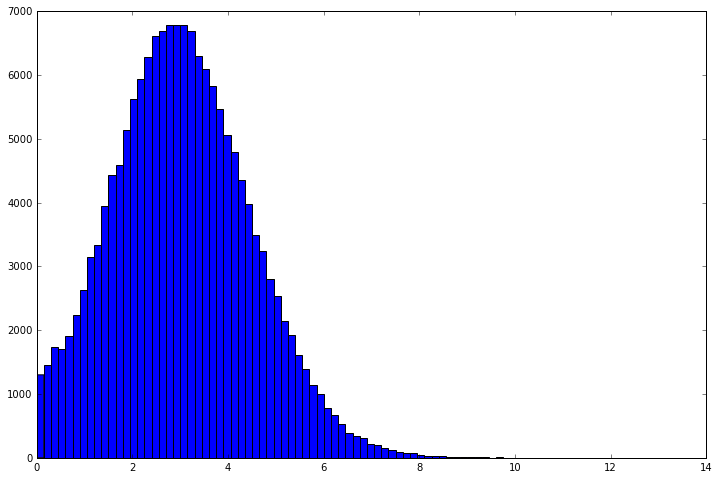

In [77]:
plt.figure(figsize = (12, 8));
plt.hist(local_ratings, bins = 80);

### Apply Threshold

In [78]:
# value validated in Spark_Recommendation_Model_Validation notebook
threshold = 9

In [80]:
validated_user_recs = user_recs.filter(lambda row: row[2] >= threshold )

### Make Recommendations Human Readable
    Retreive the users customerhash and the wine's features

In [87]:
validated_user_recs.take(5)

[Rating(user=100, product=76737, rating=9.43446552597446),
 Rating(user=100, product=374880, rating=10.669865278252697),
 Rating(user=100, product=102366, rating=9.012218641252758),
 Rating(user=100, product=190677, rating=9.01926121814591),
 Rating(user=100, product=173754, rating=10.166848250514818)]

In [106]:
cust_tag_bridge_rdd.map(lambda row: (row[1], row[0])).take(5)

[(0, '00000F7264C27BA6FEA0C837ED6AA0AA'),
 (100, '0000BE4B3C81E1CEF858D536BB740052'),
 (200, '0000CFF17C117A02813740C93DC33507'),
 (300, '000233FB8CBD3FCD20304423156CDF39'),
 (400, '0002891908E9F41F05F440792B4FF2E7')]

In [115]:
# format --> (product key, predicted rating, user hash tag)
wineID_rating_userHash = \
validated_user_recs.map(lambda row:  (row[0], (row[1], row[2]) )  )\
                   .join(cust_tag_bridge_rdd\
                   .map(lambda row: (row[1], row[0])))\
                   .map(lambda row: ( row[1][0][0],
                                      (row[1][0][1],
                                      row[1][1] ) ))

In [120]:
wineID_rating_userHash.join(products_rdd).take(1)

[(18594,
  ((9.31494187084013, '0000BE4B3C81E1CEF858D536BB740052'),
   (116127,
    'Columbia Valley',
    'Chardonnay',
    'Columbia Crest',
    'White Wines')))]

In [127]:
# Key:Value pair RDD
# format --> (custumer tag, (productKey , productID, Appellation, Varietal, Vineyard, wine type, Rating  ) )  
clean_user_recs = \
wineID_rating_userHash.join(products_rdd)\
                      .map(lambda row: ( row[1][0][1], 
                                         (row[0], 
                                          row[1][1][0], 
                                          row[1][1][1], 
                                          row[1][1][2], 
                                          row[1][1][3],
                                          row[1][1][4],
                                          row[1][0][0])))

In [128]:
clean_user_recs.take(2)

[('0000BE4B3C81E1CEF858D536BB740052',
  (18594,
   116127,
   'Columbia Valley',
   'Chardonnay',
   'Columbia Crest',
   'White Wines',
   9.31494187084013)),
 ('0000BE4B3C81E1CEF858D536BB740052',
  (173754,
   117076,
   'Sonoma County',
   'Cabernet Sauvignon',
   'Alexander Valley Vineyards',
   'Red Wines',
   10.166848250514818))]

In [ ]:
def format_user_recs(user_recs, cust_tag_bridge_rdd, thresh = 9):
    '''Reformat user recommendations so it's human readable and in preperation for curation.
       This function swaps the user_id back to the original user hash tag, and attachs the wine
       features (i.e. productID, appellation, varieatl, ...) '''
    
    # value validated in Spark_Recommendation_Model_Validation notebook
    threshold = thresh
    validated_user_recs = user_recs.filter(lambda row: row[2] >= threshold )
    
    # format --> (product key, predicted rating, user hash tag)
    wineID_rating_userHash = \
    validated_user_recs.map(lambda row:  (row[0], (row[1], row[2]) )  )\
                       .join(cust_tag_bridge_rdd\
                       .map(lambda row: (row[1], row[0])))\
                       .map(lambda row: (row[1][0][0],
                                        (row[1][0][1],
                                         row[1][1] ) ))  
    # Key:Value pair RDD
    # format --> (custumer tag, (productKey , productID, Appellation, Varietal, Vineyard, wine type, Rating  ) )  
    clean_user_recs = \
    wineID_rating_userHash.join(products_rdd)\
                          .map(lambda row: ( row[1][0][1], 
                                             (row[0], 
                                              row[1][1][0], 
                                              row[1][1][1], 
                                              row[1][1][2], 
                                              row[1][1][3],
                                              row[1][1][4],
                                              row[1][0][0])))
    return clean_user_recs

### Curate Recommendations into Varietal Sub-Genres
    Return the top 3 rated wines from the the top 3 most recommended varietals. 
    If above condition can't be met, 
    Then the top 5 reds and the top 5 whites. 

### Return the top 3 rated wines from the the top 3 most recommended varietals

In [141]:
# (custumer tag,  (productKey , productID, Appellation, Varietal, Vineyard, wine type, Rating  ) )
user_recs_dicts = clean_user_recs.collect()

In [183]:
user_recs_dicts[0]

('0000BE4B3C81E1CEF858D536BB740052',
 (18594,
  116127,
  'Columbia Valley',
  'Chardonnay',
  'Columbia Crest',
  'White Wines',
  9.31494187084013))

In [144]:
varietals = [row[1][3] for row in user_recs_dicts]

In [184]:
var_count = Counter(varietals)

##### Check condition 1: at least 3 varietals with 3 or more recommended wines

In [188]:
# check 1 -->  varietal count
len(var_count)

17

In [209]:
var_count.most_common()[0:3]

[('Cabernet Sauvignon', 8), ('Chardonnay', 6), ('Merlot', 5)]

In [276]:
# check wine count
def check_top_varietal_wine_count(most_common_varietals):
    cnt = 0
    for row in most_common_varietals:
        if row[1] >= 3:
            cnt += 1
    return cnt

#### Check condition 2: at least 3 or more wines from each top varietal

In [278]:
# check 2 --> top 3 varietals have at least 3 wines to choose from
check_top_varietal_wine_count(var_count.most_common()[0:3]) == 3

True

In [194]:
# get top 3 most recommender varietals for this user
top_varietals =  [row[0] for row in var_count.most_common()[0:3]] 

In [210]:
top_varietals

['Cabernet Sauvignon', 'Chardonnay', 'Merlot']

In [206]:
top_varietal_recs = clean_user_recs.filter(lambda row: row[1][3] in  top_varietals ).collect()

In [20]:
def curate_top_wines(top_varietal_recs):
    final_recs = defaultdict(list)
    for var in top_varietals:
        var_cnt = 1
        for row in top_varietal_recs:
            if row[1][3] == var:
                if var_cnt <= 3:
                    var_cnt += 1
                    #final_recs.append((row[0], row[1][:-1]))
                    final_recs[row[0]].append(row[1][:-1])
    return final_recs

In [ ]:
def get_top_rec_varietals(clean_user_recs):
    '''Returns the top 3 wines from the top 3 varietals for user'''
    
    # { custumer tag : (productKey , productID, Appellation, Varietal, Vineyard, wine type, Rating  ) }
    user_recs_dicts = clean_user_recs.collect()
    
    var_count = Counter(varietals)
    
    # get top 3 most recommender varietals for this user
    top_varietals =  [row[0] for row in var_count.most_common()[0:3]] 
    
    top_varietal_recs = clean_user_recs.filter(lambda row: row[1][3] in  top_varietals ).collect()
    
    return curate_top_wines(top_varietal_recs)

In [262]:
# {custumer tag : (productKey , productID, Appellation, Varietal, Vineyard, wine type, Rating  ) )
print final_recs.keys()[0]
final_recs.values()[0]

0000BE4B3C81E1CEF858D536BB740052


[(173754,
  117076,
  'Sonoma County',
  'Cabernet Sauvignon',
  'Alexander Valley Vineyards',
  'Red Wines'),
 (102366,
  123556,
  'Sonoma County',
  'Cabernet Sauvignon',
  'Kendall-Jackson',
  'Red Wines'),
 (258913,
  105847,
  'Napa Valley',
  'Cabernet Sauvignon',
  'Beaulieu Vineyard',
  'Red Wines'),
 (18594,
  116127,
  'Columbia Valley',
  'Chardonnay',
  'Columbia Crest',
  'White Wines'),
 (332048, 114203, 'Napa Valley', 'Chardonnay', 'Markham', 'White Wines'),
 (153078,
  91585,
  'Margaret River',
  'Chardonnay',
  'Leeuwin Estate',
  'White Wines'),
 (222328, 119107, 'Sonoma County', 'Merlot', 'Souverain', 'Red Wines'),
 (264575, 140541, 'Sonoma County', 'Merlot', 'St. Francis', 'Red Wines'),
 (13011, 120169, 'Napa Valley', 'Merlot', 'Irony', 'Red Wines')]

### If above condition can't be met, Then the top 5 reds and the top 5 whites. 

In [21]:
def get_top_reds_and_whites(clean_user_recs):
    '''Returns top rated wines, 5 red and 5 white '''

    # { custumer tag : (productKey , productID, Appellation, Varietal, Vineyard, wine type, Rating  ) }
    user_recs_dicts = clean_user_recs.collect()
    
    red_white_recs_dict = defaultdict(list)
    white_cnt = 1
    red_cnt = 1
    for rec in user_recs_dicts:
        if rec[1][5] == "White Wines":
            if white_cnt <= 5:
                red_white_recs_dict[rec[0]].append(rec[1])
                white_cnt += 1
        else:
            if red_cnt <= 5:
                red_white_recs_dict[rec[0]].append(rec[1])
                red_cnt += 1
                
    return red_white_recs_dict

In [294]:
red_white_recs_dict = defaultdict(list)
white_cnt = 1
red_cnt = 1
for rec in user_recs_dicts:
    if rec[1][5] == "White Wines":
        if white_cnt <= 5:
            red_white_recs_dict[rec[0]].append(rec[1])
            white_cnt += 1
    else:
        if red_cnt <= 5:
            red_white_recs_dict[rec[0]].append(rec[1])
            red_cnt += 1

In [297]:
print red_white_recs_dict.keys()[0]
red_white_recs_dict.values()[0]

0000BE4B3C81E1CEF858D536BB740052


[(18594,
  116127,
  'Columbia Valley',
  'Chardonnay',
  'Columbia Crest',
  'White Wines',
  9.31494187084013),
 (173754,
  117076,
  'Sonoma County',
  'Cabernet Sauvignon',
  'Alexander Valley Vineyards',
  'Red Wines',
  10.166848250514818),
 (57186,
  87909,
  'Russian River',
  'Zinfandel',
  'DeLoach',
  'Red Wines',
  9.085938853885436),
 (331479,
  143384,
  'Other California',
  'Pinot Noir',
  'Chateau St. Jean',
  'Red Wines',
  10.101814034176321),
 (333234,
  96689,
  'Priorat',
  'Other Red Blends',
  'Mas Doix',
  'Red Wines',
  9.318783239714847),
 (102366,
  123556,
  'Sonoma County',
  'Cabernet Sauvignon',
  'Kendall-Jackson',
  'Red Wines',
  9.012218641252758),
 (42040,
  109650,
  'Mosel-Saar-Ruwer',
  'Riesling',
  'S.A. Prum',
  'White Wines',
  9.719795281461451),
 (422858,
  128536,
  'Marlborough',
  'Sauvignon Blanc',
  'The Seeker',
  'White Wines',
  9.313705611694452),
 (332048,
  114203,
  'Napa Valley',
  'Chardonnay',
  'Markham',
  'White Wines',
  